# DBSCAN
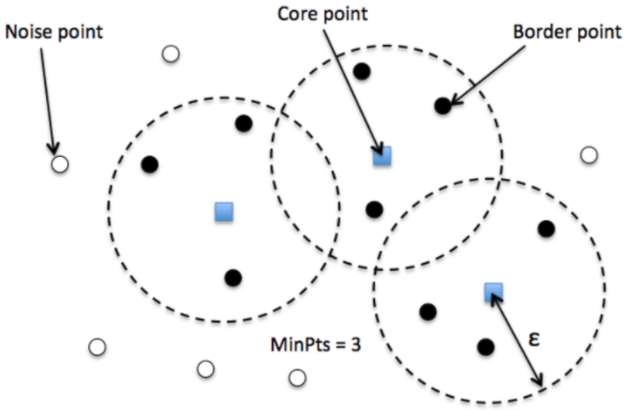

# Overview
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm used in machine learning to group together data points that are close to each other in space. DBSCAN is a density-based clustering algorithm that doesn't require the user to pre-specify the number of clusters, and can identify clusters of arbitrary shape.

# Advantage
1. Can handle clusters of arbitrary shape and its ability to identify noise points. 
2. Less sensitive to the initial position of the data points and can handle datasets with varying densities.

# Disadvantage
1. Very sensitive to the choice of hyperparameters such as the epsilon and minimum points.
2. High computational complexity for large datasets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import cluster, datasets
import random
import warnings
warnings.filterwarnings('ignore')

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can  be any shape, as opposed to k-means which assumes that clusters are convex shaped.
K-means dont work well in make moon data for example.

<Axes: >

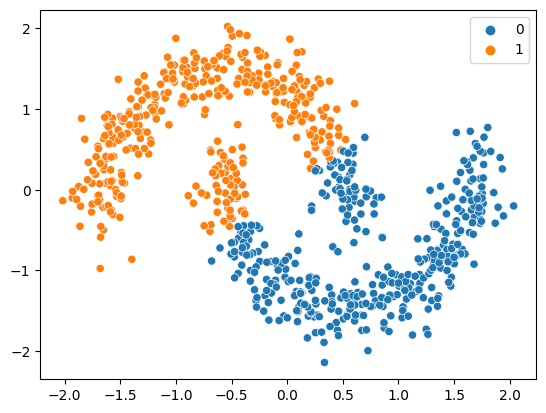

In [2]:
random.seed(30)
X, y = make_moons(n_samples=750, shuffle=True, noise=0.11, random_state=42)
X = StandardScaler().fit_transform(X)


km=cluster.KMeans(n_clusters=2)
km.fit(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=km.labels_)

We create a function to measure distance (epsilon) of the selected data point.

In [3]:
def distance(p, q):
    return np.sqrt(np.sum((p-q)**2))

distance(X[0], X[-1])

2.462733718089096

The DBSCAN algorithm starts by:
1. Selecting a random data point from the dataset.
It then checks to see if there are at least a minimum number of other data points within a certain distance (epsilon) of the selected data point. These data points are called core points.

2. If there are enough core points nearby, then all of the core points (including the original selected data point) are considered to be part of the same cluster. If there aren't enough core points nearby, then the selected data point is marked as noise and excluded from any clusters.

3. The algorithm repeats this process for each unvisited data point in the dataset until all points have been visited.

We implent all our helper methods and our python class of DBSCAN below.

In [4]:
#Return the indices of all points within epsilon distance of a given point
def find_neighbors(X, point, eps):
    indices = []
    for i, p in enumerate(X):
        if distance(p, point) <= eps:
            indices.append(i)
    return indices

find_neighbors(X, X[-1], 0.3)

[146, 151, 164, 193, 253, 318, 383, 410, 632, 746, 749]

In [5]:
# We can create a list that mark if a point is visited with 1, unvisited with 0
def find_unvisited_neighbors(lst):
    unvisited_indices = [i for i in range(len(lst)) if lst[i] == 0]
    if len(unvisited_indices) > 0:
        return np.random.choice(unvisited_indices)
    else:
        return -1

# Test on toy set  
visited = [1, 0, 0, 1, 1, 1, 0, 1, 1, 0]
find_unvisited_neighbors(visited)

9

We start by selecting a random point.

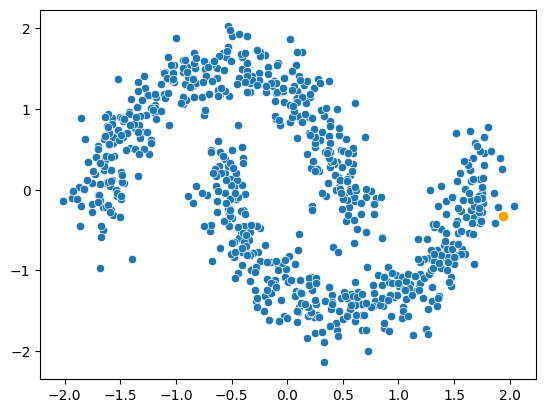

In [6]:
unvisited_point = find_unvisited_neighbors(np.zeros(len(X)))
sns.scatterplot(x=X[:, 0], y=X[:, 1]) 
plt.scatter(X[unvisited_point, 0], X[unvisited_point, 1], c = 'orange')

We can update our inital point's neighbors to be in the same cluster.

<Axes: >

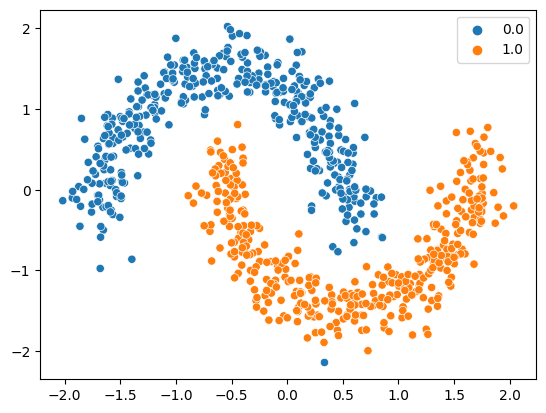

In [7]:
def update_neighbors(X, cluster_number, cluster_labels, unvisited_point, visited, neighbors, min_points, eps):
    cluster_labels[unvisited_point] = cluster_number
    neighbors.remove(unvisited_point)
    for i in neighbors:
        # Skip if neighbor is already visited
        if visited[i] == 1:
            continue
        visited[i] = 1
        # Find neighbors of neighbors
        i_neighbors = find_neighbors(X, X[i, :], eps)
        if len(i_neighbors) >= min_points:
            neighbors.extend(i_neighbors)
        cluster_labels[i] = cluster_number
    return [cluster_labels, visited, neighbors]

# Counter for number of clusters
cluster_number = 0              
# List that holds label of cluster
cluster_labels = np.zeros(len(X))      
# List that mark if point is being visited     
visited = np.zeros(len(X))
# Choose an unvisited point
visited[unvisited_point] = 1
neighbors = find_neighbors(X, X[unvisited_point], 0.3)
cluster_number = cluster_number + 1
[cluster_labels, visited, neighbors] = update_neighbors(X, cluster_number, cluster_labels, unvisited_point, visited, neighbors, 10, 0.3)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels)  

While the plot does shows two distinct cluster, we still have to iterate through every unvisted points to classify each point as either belonging to a cluster or just noise. We implement the DBSCAN class below to do just that.

In [8]:
class DBSCAN(object):
    
    def __init__(self, X, min_points = 10, eps = 0.3):
        self.min_points = min_points
        self.eps = eps
        self.cluster_number = 0     
        self.cluster_labels = np.zeros(len(X))
        self.visited = np.zeros(len(X))
        
    def train(self, X):
        unvisited_point = find_unvisited_neighbors(self.visited)
        self.visited[unvisited_point] = 1
        neighbors = find_neighbors(X, X[unvisited_point], self.eps)
        if len(neighbors) < self.min_points:
            cluster_labels[unvisited_point] = 0 # Mark as noise
        else:
            self.cluster_number = self.cluster_number + 1
            [self.cluster_labels, self.visited, neighbors] = update_neighbors(X, self.cluster_number, self.cluster_labels, unvisited_point, self.visited, neighbors, self.min_points, self.eps)
        if find_unvisited_neighbors(self.visited) != -1:
            self.train(X)   
    
    def predict(self):
        return self.cluster_labels

We can now create a DBSCAN class instance and visualize our final clustering.

<Axes: >

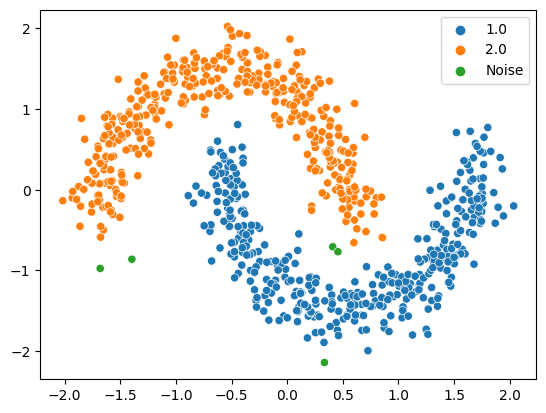

In [9]:
dbscan = DBSCAN(X, min_points = 10, eps = 0.3) 
dbscan.train(X)
cluster_labels = dbscan.predict()
cluster_labels = np.where(cluster_labels == 0, "Noise", cluster_labels)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels)  

# Conclusion
As we see above, DBSCAN is much better than k-means when it comes to dataset like make-moon. DBSCAN can handle clusters of arbitrary shape and size, and can detect noise and outliers. Additionally, it does not require the user to specify the number of clusters beforehand unlike k-means.